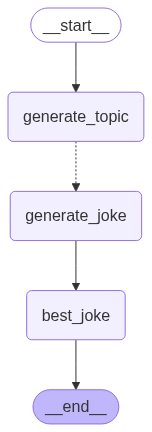

{'topic': ['lions', 'elephants', 'penguins'],
 'jokes': ["Why don't lions like fast food? Because they can't catch it!",
  "Why don't elephants use computers? They're afraid of the mouse!",
  "Why don't penguins like talking to strangers at parties? Because they find it hard to break the ice."],
 'best_joke': 'penguins'}

In [ ]:
# from typing_extensions import TypedDict,Annotated
# from operator import add
# class OverallState(TypedDict):
#     topic:str
#     subject : list[str]
#     jokes : Annotated[list[str] , add]
#     best_joke : str

# def generate_topic( overallstate:OverallState):
#     return {"topic":["lions","elephants","penguins"]}

# def generate_joke(overallstate: OverallState):
#     joke_map = {
#         "lions": "Why don't lions like fast food? Because they can't catch it!",
#         "elephants": "Why don't elephants use computers? They're afraid of the mouse!",
#         "penguins": "Why don't penguins like talking to strangers at parties? Because they find it hard to break the ice."
#     }
#     return {"jokes": [joke_map[overallstate["subject"]]]}

# from langgraph.types import Send
# def continue_to_joke(overallstate: OverallState):
#     return [Send("generate_joke", {"subject" : s }) for s in overallstate["topic"]]

# def best_joke(overallstate: OverallState):
#     return {"best_joke": "penguins"}

# from langgraph.graph import StateGraph,START,END

# graph_builder = StateGraph(OverallState)
# graph_builder.add_node("generate_topic",generate_topic)
# graph_builder.add_node("generate_joke",generate_joke)
# graph_builder.add_node("best_joke",best_joke)
# # graph_builder.add_node("continue_to_joke",continue_to_joke)

# graph_builder.add_edge(START,"generate_topic")
# graph_builder.add_conditional_edges("generate_topic",continue_to_joke,["generate_joke"])
# graph_builder.add_edge("generate_joke","best_joke")
# graph_builder.add_edge("best_joke",END)
# # graph_builder.add_edge('llm_call_3',END)

# graph = graph_builder.compile()

# from IPython.display import Image,display

# display(Image(graph.get_graph().draw_mermaid_png()))

# graph.invoke(OverallState())

In [ ]:
# initialising the llm
# from dotenv import load_dotenv
# import os
# load_dotenv()

# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o",api_key="your api key")
result = llm.invoke("what is capital of india")
print(result)

content='The capital of India is New Delhi.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 12, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BxA7704MbQyLg25FT50gEPAlIVDFW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--64d0f4d1-d41b-4bfb-a335-ce28c58f4132-0' usage_metadata={'input_tokens': 12, 'output_tokens': 8, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [2]:
from pydantic import BaseModel,Field
class Section(BaseModel):
    name:str = Field(description='name of the section')
    description: str =Field(description="decription of the section")

class Sections(BaseModel):
    sections:list[Section] = Field("list of sections of the report")

planner = llm.with_structured_output(Sections)

# result = planner.invoke("write a article on mouse")
# result

In [3]:
# for section in result.sections:
#     print(section.name)

In [4]:
from typing_extensions import TypedDict,Annotated
from operator import add
class State(TypedDict):
    input : str
    sections : list[Section]
    section_results : Annotated[list[str],add]
    final_report : str

class WorkerState(TypedDict):
    section : str
    section_result : Annotated[list[str],add]
    

In [17]:
def orchestator(state : State):
    return {'sections':planner.invoke(state["input"]).sections}

def llm_call(state:WorkerState):
    return {"section_results":[llm.invoke(f"write a report on section {state["section"].name} having discription{state["section"].description}").content]}

from langgraph.types import Send
def assign_worker(state:State):
    return [Send("llm_call",{"section": s }) for s in state["sections"]]

def synthesizer(state:State):
    final_report = "\n\n\n---\n\n\n".join(state["section_results"])
    return {"final_report" : final_report}

In [18]:
from langgraph.graph import StateGraph,START,END

graph_builder = StateGraph(State)
graph_builder.add_node('orchestator',orchestator)
graph_builder.add_node("llm_call",llm_call)
graph_builder.add_node("synthesizer",synthesizer)
# graph_builder.add_node("assign_worker",assign_worker)

graph_builder.add_edge(START,"orchestator")
#["llm_call"] is the target node name(s) to send those Send objects to.
graph_builder.add_conditional_edges("orchestator",assign_worker,["llm_call"])
graph_builder.add_edge("llm_call","synthesizer")
graph_builder.add_edge("synthesizer",END)

graph = graph_builder.compile()


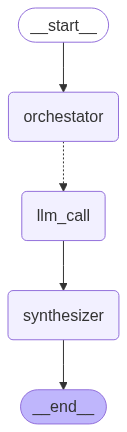

In [19]:
from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
#write your query example wrtie a article on computer mouse
state = graph.invoke({"input":"your query"})

from IPython.display import Markdown
Markdown(state["final_report"])

**Introduction to Mice**

Mice, belonging to the order Rodentia, are small mammals characterized by their adaptability and prolific reproductive capabilities. These traits have not only enabled their survival across diverse environments but have also allowed them to flourish in close proximity to human habitation. Despite their small size, the impact of mice is profound, influencing ecological balance, scientific research, and even popular culture.

Biologically, mice are known for their rapid breeding cycles which contribute significantly to their adaptability. A single pair of mice can produce numerous offspring within a short time, facilitating swift population growth. This characteristic is advantageous for their survival and makes them a key species in the food chain, serving as a primary food source for various predators, including birds of prey, reptiles, and mammals. Their role as prey supports the biodiversity and health of ecosystems by contributing to the dietary needs of multiple animal species.

Moreover, mice are integral to seed distribution, acting as vectors that inadvertently promote plant growth and forest regeneration. Their foraging activities enable seed dispersal over a wide area, supporting the propagation of various plant species. This ecological function underscores the significance of mice in maintaining the balance and sustainability of natural habitats.

Beyond their ecological contributions, mice have had a notable impact on human development and cultural landscapes. In scientific research, laboratory mice are invaluable due to their genetic, biological, and behavioral similarities to humans. They serve as model organisms in diverse fields such as genetics, pharmacology, and disease research, facilitating advancements in medical science and healthcare. The ability to manipulate mouse genomes has led to critical insights into human diseases, resulting in improved treatments and therapeutic approaches.

In popular culture, mice have captured the human imagination in stories, folklore, and entertainment. Iconic characters like Mickey Mouse have become symbols of creativity and innovation, illustrating the cultural impact these small rodents have had on societies worldwide.

In conclusion, mice, despite their size, play vital roles in ecological, scientific, and cultural contexts. Their adaptability and reproductive success ensure their place in ecosystems, supporting biodiversity and ecological functions. Additionally, their contributions to scientific research have significantly advanced human understanding of biology and medicine. As creatures that inspire and educate, mice continue to be prominent figures in both the natural world and human society.


---


# Report on Species and Population: Mice

## Introduction

Mice, small rodents belonging to the family Muridae, are one of the most widespread and adaptive groups of mammals on the planet. Their ability to thrive in diverse environments is a testament to their evolutionary success. This report focuses on the species classification and population dynamics of mice, emphasizing their adaptability and ecological significance.

## Species Classification

Mice are broadly categorized into two main groups:

### 1. Domestic Mice (Mus musculus)

- **Description**: Commonly known as house mice, Mus musculus is the most recognized species within the mice family. These mice are often found in human habitats, where they thrive due to the availability of food and shelter. They are characterized by their small size, pointed snouts, large ears, and a long, hairless tail.
  
- **Habitat and Distribution**: Domestic mice are predominantly found in urban and suburban settings worldwide. Due to their close association with humans, they have been introduced to nearly every part of the globe, except for the Antarctic regions.

### 2. Wild Mice

The category of wild mice includes a variety of species, some of the most notable being:

- **Deer Mice (Peromyscus spp.)**: Known for their agile movements and bicolored tails, deer mice are widely distributed across North America. They inhabit forests, grasslands, and sometimes human structures in rural areas.

- **Field Mice (Apodemus spp.)**: These mice are commonly found in Europe and parts of Asia. They are adept at living in fields, hedgerows, and woodlands, and are known for their burrowing behavior.

- **Other Subspecies**: This group includes several other species adapted to specific regions and ecological niches. Examples include the African pygmy mouse, the spiny mouse, and more, each possessing unique adaptations to their habitats.

## Population Dynamics

Mice populations are influenced by a myriad of factors, ranging from environmental conditions to predation pressures. Key aspects include:

- **Reproductive Rate**: Mice have a high reproductive rate, with females capable of producing multiple litters each year. This biological characteristic allows their populations to expand rapidly under favorable conditions.

- **Adaptability**: The ability of mice to exploit a wide range of food sources and habitats contributes to their success. They are known to consume seeds, grains, fruits, insects, and human refuse. Their behavioral flexibility facilitates survival in urban and rural settings alike.

- **Predation and Control**: Natural predators of mice include birds of prey, snakes, and various carnivorous mammals. Humans also manage mouse populations through pest control measures, especially in urban areas where their presence can pose health risks.

- **Habitat Modification**: Human activities, such as agriculture and urban development, can both positively and negatively affect mouse populations. While some species benefit from the resources provided by agricultural lands, others may be displaced by habitat destruction and environmental changes.

## Ecological Significance

Mice play a crucial role in ecosystems as both prey and consumers. They are an integral part of the food chain, supporting a wide range of predators. Additionally, mice contribute to seed dispersal and soil aeration through their foraging and burrowing activities.

## Conclusion

Mice, with their diverse species and widespread populations, are a key component of many ecosystems. Their ability to adapt and thrive in a variety of habitats underscores their evolutionary success. Understanding the dynamics of mouse populations and their ecological roles is essential for both wildlife management and pest control strategies. As we continue to modify natural environments, the adaptation and impact of mice will remain a significant aspect of ecological studies.


---


**Report on Section: Physical Characteristics of Mice**

Mice are fascinating creatures, widely recognized for their distinctive physical features and adaptability to various environments. This report aims to provide an in-depth exploration of the physical characteristics that define mice, contributing to their survival and success in diverse habitats.

**Body Structure:**

Mice are typically characterized by their small, slender bodies, designed for agility and swift movement. Their diminutive size enables them to navigate through narrow spaces, an essential trait for avoiding predators and seeking shelter. This physical adaptation is one of the critical features that facilitate their survival in the wild and in human-dominated spaces.

**Facial Features:**

One of the most distinguishing features of mice is their pointed noses. This sharp, tapered snout is not merely a characteristic facial feature but plays a crucial role in their enhanced sense of smell. The olfactory capabilities of mice are highly developed, allowing them to efficiently locate food and detect predators. Their facial structure aligns perfectly with their sensory needs, contributing to their effectiveness as foragers.

**Tail Design:**

A notable aspect of a mouse's anatomy is its long tail, which often accounts for nearly half of its body length. The tail serves multiple purposes. It acts as a counterbalance, aiding in swift changes of direction and maintaining stability when moving quickly. The tail is also essential for thermoregulation, helping to dissipate heat in warm environments, and is sometimes used for communication.

**Fur and Coloration:**

The coat of a mouse is covered with a layer of soft fur, which provides insulation and protection. The fur's color and pattern can vary significantly, depending on the species and geographical location. This variability in fur characteristics not only aids in camouflage, blending into different environments to evade predators, but it also reflects the diverse adaptability of mice to different climatic conditions.

**Sensory Capabilities:**

Mice are renowned for their keen senses, particularly hearing and smell, which are pivotal in their daily survival strategies. Their auditory sense is highly developed, allowing them to detect a wide range of sound frequencies, including ultrasonic sounds. This acute sense of hearing is vital for communication and predator avoidance. Additionally, their exceptional sense of smell is instrumental in identifying food sources and recognizing pheromones, which play a crucial role in social interactions and reproduction.

**Conclusion:**

The physical characteristics of mice—encompassing their body structure, facial features, tail, fur, and sensory capabilities—highlight an intricate blend of traits that have evolved to meet the demands of various environments. These features not only support their basic survival but also underline their adaptability and resilience as a species. Understanding these physical traits provides insight into the ecological success of mice and their fascinating role in the animal kingdom.


---


### Report on Section: Diet and Behavior of Mice

#### Introduction
Mice are small mammals commonly found in various environments across the globe. Their survival and adaptability can be largely attributed to their dietary habits and behavior. This report discusses the diet and behavior section related to mice, focusing on their omnivorous nature, scavenging tendencies, and nocturnal activities.

#### Diet
Mice are characterized as omnivorous creatures, which means their diet comprises both plant-based and animal-based foods. Primarily, mice have a strong preference for grains, seeds, and fruits which provide essential nutrients and energy for their active lifestyle. These food sources are abundant in various environments, making them a staple in a mouse's diet.

However, mice are not restricted to these food items alone. They are opportunistic scavengers, which means that they will consume a wide variety of substances when their preferred food is scarce. This adaptability in diet helps mice survive in different environments where food availability may fluctuate seasonally or due to other ecological factors. They can feed on insects, small invertebrates, and even human food waste when necessary.

#### Behavioral Patterns
One of the defining characteristics of mice behavior is their nocturnal activity. Being nocturnal means that mice are primarily active during the night. This adaptation is advantageous for several reasons:

- **Predator Avoidance**: By being active at night, mice can evade diurnal predators, increasing their chances of survival.
  
- **Thermoregulation**: Nighttime activity helps in avoiding the heat of the day, which is particularly beneficial in warmer climates.
  
- **Foraging Efficiency**: Cooler nighttime temperatures may slow down predators while improving the scent trails for foraging, thus aiding mice in finding food.

Mice rely on their heightened senses, particularly their sense of smell, sight, and hearing, to navigate and forage in the dark efficiently. Their whiskers also play a crucial role in helping them sense changes in their environment, allowing them to detect obstacles, predators, or potential food sources through touch.

#### Conclusion
The dietary habits and behavior of mice are a testament to their adaptability and survival instinct. Their omnivorous diet, coupled with opportunistic scavenging, allows them to thrive in diverse environments. Nocturnal habits further enhance their chances of survival by leveraging the cover of darkness to avoid predators and efficiently forage for food. Understanding these facets of mouse ecology provides valuable insights into their role in ecosystems and their interactions with other species, including humans.


---


**Impact on Ecosystems:**

Mice serve as pivotal components in their ecosystems, primarily due to their roles as both prey and facilitators of plant propagation. This dual function underscores their significance in maintaining ecological balance and biodiversity.

**Role as Prey:**
Mice are essential prey for a variety of predators, such as birds of prey, snakes, and larger mammals. Their abundance and reproductive capacity make them a reliable food source, supporting the population dynamics of these predators. By sustaining the energy requirements of their hunters, mice contribute indirectly to the control of other species populations, influencing the overall food web structure.

**Contribution to Seed Dispersal:**
Beyond their function as prey, mice are instrumental as seed dispersers. Many plant species rely on mice for the distribution of their seeds, which is crucial for germination and the expansion of plant populations. This role is vital for maintaining plant diversity within ecosystems. As mice collect and store seeds, they inadvertently sow future generations of plants, enhancing forest regeneration and increasing habitat complexity.

**Ecological Balance and Biodiversity:**
The activities of mice directly impact the ecological balance within their habitats. As part of the food chain, mice help sustain biodiversity by supporting predator species and allowing for plant species diversity through seed dispersal. Their actions can lead to changes in vegetation patterns, which in turn affect the habitat and food availability for other species. This interconnectedness illustrates the importance of mice in maintaining the integrity of ecosystems.

Overall, mice embody a critical link in both terrestrial and semi-aquatic environments. Their survival and activities can leave a cascading impact on numerous species and ecological processes, highlighting the necessity for understanding and conserving their populations within ecosystems.


---


**Report: Section on Mice in Research**

**Introduction**

Laboratory mice have emerged as a cornerstone of scientific research, providing unparalleled insights into various biological processes and aiding in advancements in medicine. Their widespread use in laboratories around the world can be attributed to several key factors, including their genetic similarity to humans and their efficient reproductive capabilities. This report delves into the role of mice in research, highlighting their contributions to genetics, cancer studies, neurobiology, and infectious diseases.

**Genetic Similarity to Humans**

One of the primary reasons mice are invaluable in research is their genetic resemblance to humans. Approximately 85% of the mouse genome is similar to the human genome, making mice excellent models for studying human diseases. This genetic compatibility allows researchers to investigate the functions of specific genes and understand genomic influences on health and disease. Genetic manipulations, such as knock-out and knock-in models, enable scientists to mimic human genetic disorders in mice, providing crucial insights into disease mechanisms and potential therapeutic targets.

**Reproductive Efficiency**

Mice are also favored in research due to their rapid reproductive cycle. With a short gestation period of about 19-21 days and the ability to reproduce several times a year, mice populations can grow quickly. This allows for longitudinal studies and accelerates research timelines, facilitating the observation of generational genetic changes and the effect of interventions across different life stages.

**Contributions to Various Fields of Research**

1. **Genetics**: Mice have been instrumental in understanding genetic traits, hereditary diseases, and gene function. Their use in creating transgenic and gene-edited models has furthered knowledge in areas like developmental biology and epigenetics.

2. **Cancer Research**: Mouse models have been critical in cancer research, aiding in the identification of oncogenes and tumor suppressor genes. They are used to study tumor growth, metastasis, and the efficacy of anti-cancer drugs. By observing how tumors develop and spread in mice, researchers gain insights into similar processes in humans, paving the way for new treatments.

3. **Neurobiology**: Due to their well-mapped nervous system, mice serve as excellent subjects in neurobiological research. Studies on mice have led to advances in understanding neurodegenerative diseases like Alzheimer's, Parkinson's, and ALS. Research on mouse brain activity helps unravel the complexities of brain function and its relationship to behavior.

4. **Infectious Diseases**: Mice play a vital role in the study of infectious diseases, providing a model system to study pathogen interactions, immune responses, and vaccine efficacy. This research is crucial in developing interventions against diseases such as influenza, tuberculosis, and emerging viral infections.

**Ethical Considerations and Alternatives**

While mice provide significant benefits to research, ethical considerations regarding their use are paramount. Researchers must adhere to strict ethical guidelines to ensure humane treatment and minimize suffering. Alternatives, such as computer modeling and in vitro studies, are explored to complement and potentially reduce reliance on animal models.

**Conclusion**

Mice have become indispensable tools in scientific research, offering profound insights into genetic, neurobiological, cancer, and infectious disease studies. Their genetic similarity to humans and rapid reproduction make them ideal for a variety of research applications. While ethical considerations remain, the contributions of mice to our understanding of biology and the advancement of medicine are invaluable, making them a critical component of scientific inquiry.


---


# Report on Challenges and Management of Mice Infestations

## Section: Challenges and Management

### Introduction

Mice, though beneficial in their natural ecosystems, often become significant challenges when they invade human habitats. This section delves into the challenges posed by mice in residential and commercial sectors and explores effective management strategies to mitigate associated risks.

### Challenges of Mice Infestations

1. **Property Damage**  
   Mice have an innate need to chew on objects to keep their continually growing incisors at a manageable length. This behavior can cause extensive property damage in a human habitat. Common targets include:
   - Electrical wiring: Chewing can lead to short circuits, increasing the risk of electrical fires.
   - Insulation materials: Damage can lead to increased energy costs due to inefficiency.
   - Structural components: Burrows and nests can compromise the integrity of walls, floors, and furniture.

2. **Disease Transmission**  
   Mice are known carriers of various pathogens that can cause diseases in humans, including:
   - Hantavirus: Transmitted through inhalation of particles from mouse droppings and urine.
   - Salmonella: Spread through contaminated food and surfaces.
   - Lymphocytic choriomeningitis virus (LCMV): Can be particularly hazardous for pregnant women, potentially causing congenital disabilities.

3. **Rapid Reproduction Rate**  
   Mice can reproduce at alarming rates, with a single female capable of producing numerous offspring each year. This rapid growth can lead to uncontrollable infestation levels if not addressed promptly.

### Management Strategies

1. **Humane Traps**  
   Using humane traps is a cornerstone of ethical pest management. These devices capture mice without causing harm, allowing for live release. They are ideal for those who seek to manage infestations without resorting to lethal methods.

2. **Exclusion Methods**  
   Prevention is a key element in pest management. Exclusion methods involve modifying the environment to make it less accessible and less inviting to mice:
   - Sealing entry points: Closing gaps and cracks in walls, foundations, windows, and doors.
   - Proper storage of food: Keeping food in airtight containers to eliminate attractants.
   - Maintenance of cleanliness: Regular cleaning to eliminate food residue and reduce nesting materials.

3. **Integrated Pest Management (IPM)**  
   IPM combines different management strategies and practices to control pest populations sustainably. It involves:
   - Monitoring: Regular inspections to assess mouse activity and population levels.
   - Environment modification: Adjusting habitats to make them unfavorable for mice survival.
   - Education: Informing residents about effective practices to prevent infestations.

4. **Professional Intervention**  
   In cases of severe infestations, professional pest control services may be necessary. These experts employ advanced techniques and products to manage mice populations effectively while minimizing risks to human health and the environment.

### Conclusion

The challenges posed by mice in human dwellings necessitate proactive and effective management strategies. By utilizing humane traps, employing exclusion methods, adopting integrated pest management practices, and, when needed, seeking professional assistance, individuals and communities can mitigate the risks associated with mice infestations. These efforts not only protect property but also safeguard public health, underscoring the importance of effective pest management.


---


**Report on Cultural Significance of Mice**

**Introduction**
Mice, small and seemingly inconspicuous creatures, have cast a significant shadow over various cultural domains throughout history. These rodents have not only left their pawprints in ecological and scientific studies but have also captured the human imagination through myths, literature, movies, and more. This report explores the cultural significance of mice, focusing on their roles in mythologies, literature, and modern media.

**Ancient Mythologies**
In ancient mythologies, mice were often imbued with symbolic meanings that reflected the cultures and societies of the time. In Egyptian mythology, mice were associated with destruction and chaos but were also considered sacred in some contexts, representing the underworld. Greek mythology includes tales of Apollo Smintheus, a mouse god linked to healing and plagues, illustrating the dual nature of mice as both harbingers of disease and symbols of health.

**Literary Works**
Literature has been a fertile ground for mice to emerge as compelling characters, often embodying traits such as cleverness, resourcefulness, and resilience. The enduring appeal of these characters is evident in classic works like "The Tale of Despereaux" by Kate DiCamillo and "The Mouse and the Motorcycle" by Beverly Cleary. These stories highlight the mouse's role as an underdog capable of overcoming great odds, resonating with readers who identify with their courage and tenacity.

**Modern Media: Movies and Cartoons**
Mice have found a prominent place in modern media, particularly in movies and cartoons where they often take center stage as protagonists and beloved icons. The character of Mickey Mouse, created by Walt Disney, stands as a testament to the universal charm of mice. Since his debut in 1928, Mickey Mouse has become a cultural icon, symbolizing optimism and the spirit of adventure.

Another notable literary and cinematic character is Stuart Little, created by author E.B. White. Stuart's adventures illustrate themes of family, friendship, and finding one's place in the world. His character has resonated with audiences through both books and film adaptations, further solidifying the mouse's place in popular culture.

**Cartoon Characters and Their Impact**
Cartoon characters such as Jerry from "Tom and Jerry" and Remy from "Ratatouille" further demonstrate the appeal and versatility of mice in storytelling. These characters often embody intelligence, agility, and wit, appealing to audiences of all ages. They thrive in environments where they navigate challenges and antagonists, often with humor and grace.

**Conclusion**
Mice have undeniably woven themselves into the cultural fabric, serving as symbols of perseverance and adaptability. From ancient mythologies to contemporary media, their presence in cultural narratives showcases their unique ability to capture human imagination and empathy. As icons like Mickey Mouse and Stuart Little continue to inspire new generations, it is evident that mice will maintain their cultural significance for years to come.


---


# Report on Conservation and Ethics: Focus on Mice

## Introduction
The role of mice in various ecosystems and scientific research is substantial, despite their common perception as a non-endangered species. This report focuses on the dual aspects of conservation and ethics concerning mice, highlighting efforts to sustain their natural habitats and ensure ethical treatment in laboratory environments.

## Conservation of Mice Habitats

### Significance of Mice in Ecosystems
Mice play a crucial role in the ecosystem as prey for numerous predators, ranging from birds to mammals. They are vital for seed dispersal and contribute to the aeration and nutrient mixing of soil through their burrowing activities. The health of ecosystems can be gauged by the abundance and variety of mice that inhabit them.

### Threats to Mice Habitats
Despite not being endangered, mice face threats primarily from habitat destruction, pollution, and urbanization. Deforestation, agricultural expansion, and climate change have significantly altered natural landscapes, reducing available habitats for mouse populations.

### Conservation Efforts
Conservation initiatives aim to safeguard and restore mouse habitats to ensure ecological balance. Strategies include:
  - **Habitat Restoration**: Reforesting areas and restoring wetlands to provide suitable environments for mice.
  - **Protected Areas**: Establishing reserves and protected areas to conserve biodiversity, including mouse populations.
  - **Public Awareness and Education**: Campaigns to raise awareness about the ecological roles of mice and the importance of conservation.

## Ethical Considerations in Research

### Use of Mice in Research
Mice are extensively used in scientific research due to their genetic similarities to humans, short breeding cycles, and ease of care. They are fundamental in studies related to genetics, disease, and drug testing.

### Ethical Treatment and Guidelines
Ethical guidelines have been established to ensure that mice used in laboratories are treated humanely. Key ethical considerations include:
  - **Reduction**: Minimizing the number of mice used in research through improved study designs and data analysis.
  - **Refinement**: Enhancing experimental procedures to minimize pain and distress, using proper anesthetics and analgesics.
  - **Replacement**: Developing alternative methods and models, such as computer simulations or cultured cell systems, to reduce reliance on live animals.

### Regulatory Framework
Regulatory bodies at national and international levels have set standards for the ethical treatment of laboratory animals. Compliance with frameworks such as the Animal Welfare Act and guidelines from organizations like the National Institutes of Health (NIH) is mandatory for research institutions.

## Conclusion
Conservation and ethics with respect to mice are intertwined aspects that encompass habitat protection and the humane treatment of animals in research. Conservation efforts strive to maintain ecological integrity, while ethical practices in laboratories ensure that research is conducted responsibly. Together, these efforts can help sustain mouse populations and advance scientific knowledge in a manner that respects both nature and animal welfare. 

## Recommendations
To further the goals of conservation and ethics pertaining to mice, the following actions are recommended:
  - Strengthen collaborations between conservationists, researchers, and policymakers to harmonize efforts.
  - Increase funding and support for habitat restoration projects and ethical research practices.
  - Enhance public education initiatives to build a wider understanding of the ecological and scientific importance of mice. 

Through dedicated efforts in both conservation and ethical dimensions, we can foster an environment where mice continue to thrive in the wild and contribute significantly to scientific advancements.


---


**Conclusion**

In conclusion, the mouse, despite its diminutive size, holds an extraordinary and multifaceted role within both the natural world and human society. As an integral component of the ecosystem, mice contribute to seed dispersion, soil aeration, and serve as a crucial prey species for numerous predators, thus maintaining ecological balance. Their presence and activities underscore the complexity of natural habitats and highlight their contribution to biodiversity.

Scientifically, mice have become indispensable. They are pivotal in research settings due to their physiological and genetic similarities to humans, which provide invaluable insights into genetics, disease, and health. They are central to groundbreaking discoveries in medical research, including studies on cancer, diabetes, and neurological disorders, thereby enhancing our understanding of human biology and leading to the development of new therapies.

Culturally, mice are deeply embedded in the narratives and folklore of various societies, symbolizing everything from resourcefulness to vulnerability. Their depiction in literature, art, and media continues to adapt, reflecting societal changes and perpetuating their presence in our cultural consciousness.

Our understanding and relationship with these little rodents evolve continuously, shaping ecological, scientific, and cultural landscapes in unique and meaningful ways. As we advance and deepen our knowledge, the significance of mice remains ever-present, reinforcing their role as both a natural marvel and a cornerstone of scientific progress. The harmonious coexistence and study of mice affirm their pivotal importance and remind us of the delicate interplay between nature and society.